In [1]:
import pandas as pd 
df=pd.read_csv(r'C:\Users\DELL\Downloads\emails.csv')
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


In [9]:
df['spam'].value_counts()

0    4360
1    1368
Name: spam, dtype: int64

In [23]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

# Text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)
    # Lowercasing and removing punctuation
    tokens = [word.lower() for word in tokens if word.isalnum()]
    # Removing stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # Stemming
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

df['processed_text'] = df['text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [24]:
# Step 2: Handling Class Imbalance with Cost-Sensitive Learning
# Define the features and labels
X = df['processed_text']
y = df['spam']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Vectorize the text data
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

[[868   4]
 [ 13 261]]
              precision    recall  f1-score   support

    Not Spam       0.99      1.00      0.99       872
        Spam       0.98      0.95      0.97       274

    accuracy                           0.99      1146
   macro avg       0.99      0.97      0.98      1146
weighted avg       0.99      0.99      0.99      1146

ROC-AUC Score (Cost-Sensitive Model): 0.9986209234581129
Traditional Approach:
[[868   4]
 [ 17 257]]
              precision    recall  f1-score   support

    Not Spam       0.98      1.00      0.99       872
        Spam       0.98      0.94      0.96       274

    accuracy                           0.98      1146
   macro avg       0.98      0.97      0.97      1146
weighted avg       0.98      0.98      0.98      1146

ROC-AUC Score (Traditional Model): 0.9987464842965245


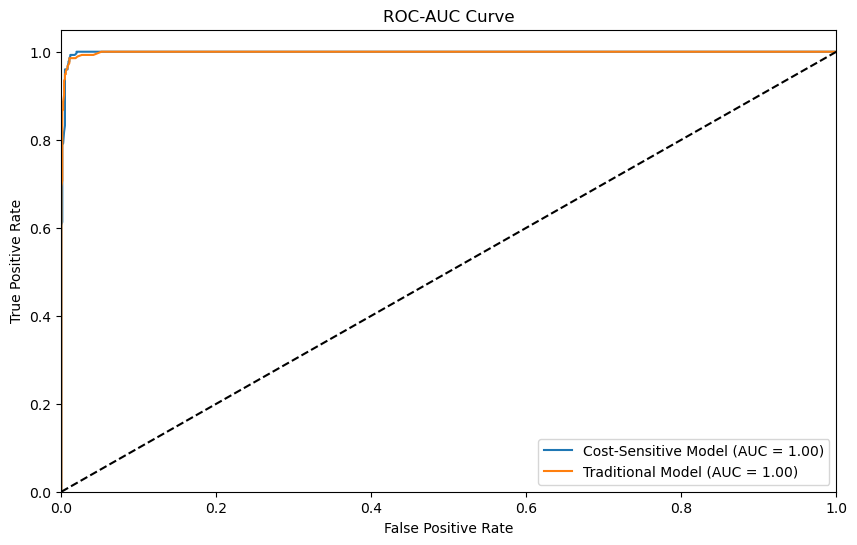

In [25]:
# Step 3: Model Development and Evaluation
# Initialize the Random Forest model with class weights
model = RandomForestClassifier(class_weight=class_weight_dict, n_estimators=100, random_state=42)

# Train the model
model.fit(X_train_tfidf, y_train)

# Evaluate the model
y_pred = model.predict(X_test_tfidf)
y_pred_proba=model.predict_proba(X_test_tfidf)[:,1]

# Print evaluation metrics
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Not Spam', 'Spam']))

# Compute ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC Score (Cost-Sensitive Model): {roc_auc}')

# Compare with traditional approach (without cost-sensitive learning)
traditional_model = RandomForestClassifier(n_estimators=100, random_state=42)
traditional_model.fit(X_train_tfidf, y_train)
y_trad_pred = traditional_model.predict(X_test_tfidf)
y_trad_pred_proba=traditional_model.predict_proba(X_test_tfidf)[:,1]
print("Traditional Approach:")
print(confusion_matrix(y_test, y_trad_pred))
print(classification_report(y_test, y_trad_pred, target_names=['Not Spam', 'Spam']))


# Compute ROC-AUC for traditional model
roc_auc_trad = roc_auc_score(y_test, y_trad_pred_proba)
print(f'ROC-AUC Score (Traditional Model): {roc_auc_trad}')

# Plot ROC-AUC curves
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
fpr_trad, tpr_trad, _ = roc_curve(y_test, y_trad_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Cost-Sensitive Model (AUC = {roc_auc:.2f})')
plt.plot(fpr_trad, tpr_trad, label=f'Traditional Model (AUC = {roc_auc_trad:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc='lower right')
plt.show()